# Analyse av manglende værdata
Denne notebooken lastes inn data om manglende værmålinger og visualiserer dem statisk
og interaktivt ved hjelp av Plotly og Dash.

### 1. Felles import for alle kodeblokker

In [5]:
import sys

import matplotlib.pyplot as plt
import plotly.express as px
from dash import Dash, html, dcc, Input, Output

sys.path.append("../missingData")
from missingdatafinder import MissingDataConverter

### 2. Last inn manglende data

In [6]:
converter = MissingDataConverter()
df_missing = converter.read_missing_values(
    "../../data/missing/missing_in_both.csv"
)
# Rens kolonnenavn og verdier
for col in ["elementId", "missing"]:
    df_missing[col] = df_missing[col].astype(str).str.strip()

# Oppsummer antall manglende per by og måletype
df_summary = (
    df_missing
    .groupby(["missing", "elementId"]).size()
    .reset_index(name="num_missing")
    .rename(columns={"missing": "city"})
)

### 3. Statisk visualisering

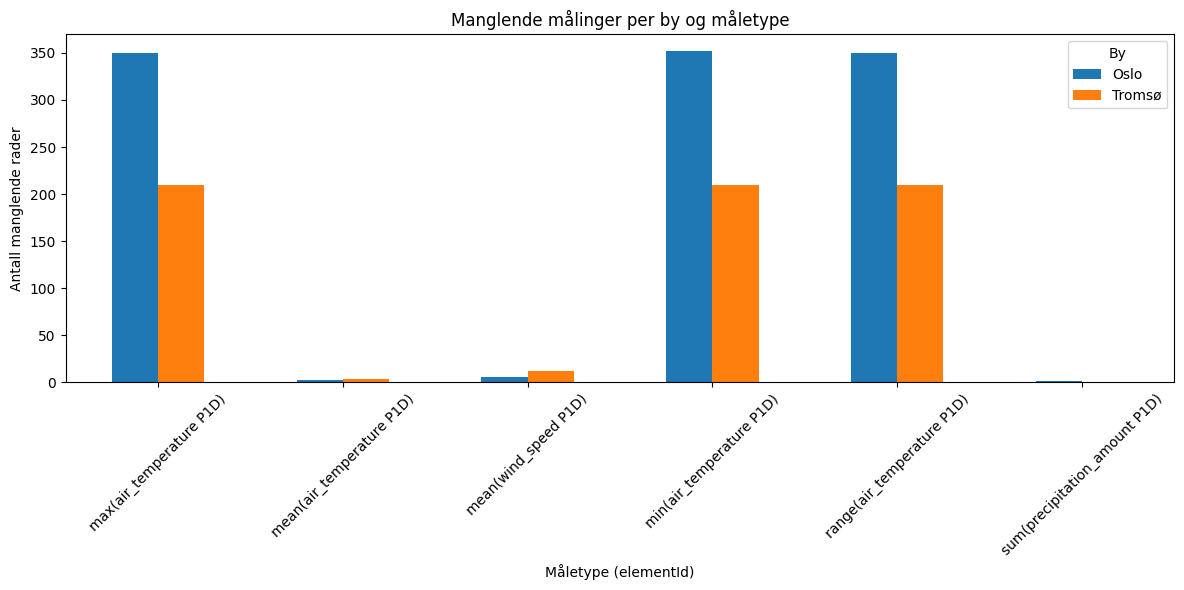

In [7]:
pivoted = df_summary.pivot(
    index="elementId", columns="city", values="num_missing"
).fillna(0)
pivoted.plot(kind="bar", figsize=(12, 6))
plt.title("Manglende målinger per by og måletype")
plt.xlabel("Måletype (elementId)")
plt.ylabel("Antall manglende rader")
plt.xticks(rotation=45)
plt.legend(title="By")
plt.tight_layout()
plt.show()

### 4. Interaktiv visualisering med Dash

In [8]:
cities = sorted(df_summary["city"].unique())
elements = sorted(df_summary["elementId"].unique())

app = Dash(__name__)
app.title = "Manglende værdata"

app.layout = html.Div([
    html.H1("Interaktiv visning av manglende værdata"),
    html.Label("Måletype:"),
    dcc.Dropdown(
        id="element-dropdown",
        options=[{"label": e, "value": e} for e in elements],
        value=elements[0],
        clearable=False,
    ),
    html.Label("By(er):"),
    dcc.Checklist(
        id="city-checklist",
        options=[{"label": c, "value": c} for c in cities],
        value=cities,
        inline=True,
    ),
    dcc.Graph(id="missing-graph"),
])

@app.callback(
    Output("missing-graph", "figure"),
    Input("element-dropdown", "value"),
    Input("city-checklist", "value"),
)
def update_graph(element_id: str, selected_cities: list[str]):
    """
    Oppdater graf basert på valgt måletype og by(er).
    """
    filtered = df_summary[
        (df_summary["elementId"] == element_id)
        & df_summary["city"].isin(selected_cities)
    ]
    fig = px.bar(
        filtered,
        x="city",
        y="num_missing",
        color="city",
        title=f"Manglende målinger for '{element_id}'",
        labels={"num_missing": "Antall manglende målinger", "city": "By"},
        text="num_missing",
    )
    fig.update_layout(template="plotly_white")
    return fig

if __name__ == "__main__":
    app.run(debug=True, port=8053)